In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import datetime
from datetime import date
import itertools
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker
import time

#### Figure aesthetics

In [2]:
#print(plt.style.available)
#plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')

#### Downlad data

In [3]:
def get_data():
    ##Get data from the source that is used to generate map (based on WHO official data):
    ##https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html?fbclid=IwAR0oKIKJlc-zeNZGFBVEN0-O-58daoCDaKicXwC10cjFWgCZqTPgavseTfI#/bda7594740fd40299423467b48e9ecf6
    url_confirmed = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
    url_deaths = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"
    url_recovered = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"
    
    for url, data_type in zip([url_confirmed, url_deaths, url_recovered], ["confirmed", "deaths", "recovered"]):
    
        r = requests.get(url)
        filename=data_type+".csv"
        f = open(filename,'wb')
        f.write(r.content)

In [4]:
get_data()

#### Prepare dataset

In [5]:
## prepare dataset
confirmed = pd.read_csv("confirmed.csv")
deaths = pd.read_csv("deaths.csv")
recovered = pd.read_csv("recovered.csv")

def reshape_single_dataset(data):
    data=data.drop(columns=["Province/State", "Lat", "Long"])
    ## aggregate data for each country
    data=data.groupby("Country/Region").sum().reset_index()
    ## reshape data
    data.reset_index(drop=True, inplace=True)
    data=data.set_index("Country/Region")
    return data

confirmed = reshape_single_dataset(confirmed)
deaths = reshape_single_dataset(deaths)
recovered = reshape_single_dataset(recovered)

In [6]:
inactive=deaths.add(recovered)
data=confirmed.subtract(inactive)
data=data.transpose().reset_index().rename(columns={'index':'Date'})
data['Date'] = pd.to_datetime(data['Date'])

#### List of countries in dataset

In [7]:
for el in data.columns:
    print(el)

Date
Afghanistan
Albania
Algeria
Andorra
Antigua and Barbuda
Argentina
Armenia
Aruba
Australia
Austria
Azerbaijan
Bahrain
Bangladesh
Belarus
Belgium
Bhutan
Bolivia
Bosnia and Herzegovina
Brazil
Brunei
Bulgaria
Burkina Faso
Cambodia
Cameroon
Canada
Cayman Islands
Chile
China
Colombia
Congo (Kinshasa)
Costa Rica
Cote d'Ivoire
Croatia
Cruise Ship
Cuba
Cyprus
Czechia
Denmark
Dominican Republic
Ecuador
Egypt
Estonia
Ethiopia
Finland
France
French Guiana
Georgia
Germany
Greece
Guadeloupe
Guinea
Guyana
Holy See
Honduras
Hungary
Iceland
India
Indonesia
Iran
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Kenya
Korea, South
Kuwait
Latvia
Lebanon
Liechtenstein
Lithuania
Luxembourg
Malaysia
Maldives
Malta
Martinique
Mexico
Moldova
Monaco
Mongolia
Morocco
Nepal
Netherlands
New Zealand
Nigeria
North Macedonia
Norway
Oman
Pakistan
Panama
Paraguay
Peru
Philippines
Poland
Portugal
Qatar
Reunion
Romania
Russia
San Marino
Saudi Arabia
Senegal
Serbia
Singapore
Slovakia
Slovenia
South Africa
Spa

#### Get populations for countries in dataset

In [8]:
#data from: https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population 
#Was manually saved to csv. 
population_df=pd.read_csv("countries_population.csv",  encoding = "ISO-8859-1", header=None, usecols=[1,2], names=["country_name", "population"])
population_df

population_df['population'] = population_df['population'].apply(lambda x: str(x).replace(",", ""))
population_df['population'] = pd.to_numeric(population_df['population'], errors="coerce")

In [9]:
dictionary_country_names={
"US":"United States",
"Congo (Kinshasa)":"Congo",
"Cote d'Ivoire":"Ivory Coast",
"Czechia":"Czech Republic",
"French Guiana":"Guyana",
"Korea, South":"South Korea",
}

countries_populations = {}

for data_country_name in data.columns[1:]:
    searchfor=[data_country_name]
    try:
        searchfor.append(dictionary_country_names[data_country_name])
    except:
        pass
    
    check_names=0
    if check_names==1:
        if len(population_df[population_df["country_name"].str.contains('|'.join(searchfor))]) != 1:
            print(" ")   
            print(data_country_name)
            print(population_df[population_df['country_name'].str.contains('|'.join(searchfor))] )
            print(population_df[population_df['country_name'].str.contains('|'.join(searchfor))]["population"].sum() )
            print(" ")
    countries_populations[data_country_name]=population_df[population_df['country_name'].str.contains('|'.join(searchfor))]["population"].sum()

/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/pandas/core/strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


#### Choose country to plot 

In [10]:
country_to_plot="Poland"
considered_countries={"predict":country_to_plot,}

In [11]:
fit_variants={
"epidemia zacznie zwalniać po 6 dniach":6.0,
"epidemia zacznie zwalniać po 10 dniach":10.0,
"epidemia zacznie zwalniać po 12 dniach":12.0,
"epidemia zacznie zwalniać po 14 dniach":14.0,
}

#### Dates to num

In [12]:
##extract data for each country, divide by population and multiply by the value of per_num
dates=data["Date"].values
dates_num = mdates.date2num(dates)
dates_start = np.min(dates_num)
dates_num = dates_num - dates_start

date_shutdown =datetime.date(2020, 3, 13)

#days_to_extrapolate=30
last_day_to_extrapolate = datetime.date(2020, 4, 13)
today=mdates.date2num(date.today())
days_to_extrapolate = mdates.date2num(last_day_to_extrapolate)
days_to_extrapolate=days_to_extrapolate-today

#### Fit

In [13]:
#num days to extrapolate

dates_num_extrapolate = np.arange(0,len(dates_num)+days_to_extrapolate,1)
#num iterations
maxit=100000
#for normalization
per_num=100000

def exponent(x, a, b, c):
    return a * np.exp(b * (x-c))

def sigmoid(x, L , k, b, x0):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return y

#fixed_sigmoid = lambda x, L , k, b: sigmoid(x, L , k, b, 64.0)

#fit exponent to data
pred_data=(data[considered_countries["predict"]].values/countries_populations[considered_countries["predict"]])*per_num
pred_exp_popt, pred_exp_pcov = curve_fit(exponent, dates_num, pred_data, maxfev=maxit)
print(pred_exp_popt)
pred_exp_fit = exponent(dates_num_extrapolate, *pred_exp_popt)


##fit unfixed sigmoid to data
pred_sig_popt, pred_sig_pcov = curve_fit(sigmoid, dates_num, pred_data, p0=[np.max(pred_data),1,1,1])
print(pred_sig_popt)

pred_sig_popt_fixed={}
pred_sig_pcov_fixed={}
pred_sig_fit_fixed={}

for variant_name, variant_value in zip(fit_variants, fit_variants.values()):
    print(variant_name, variant_value)
    
    x0 = (mdates.date2num(date_shutdown)-dates_start) + variant_value
    print (x0)
    fixed_sigmoid = lambda x, L , k, b: sigmoid(x, L , k, b, x0)

    pred_sig_popt_fixed[variant_name], pred_sig_pcov_fixed[variant_name] = curve_fit(fixed_sigmoid , dates_num, pred_data, p0=pred_sig_popt[:-1])
    pred_sig_fit_fixed[variant_name] = fixed_sigmoid(dates_num_extrapolate, *pred_sig_popt_fixed[variant_name])
    
    print(pred_sig_popt_fixed[variant_name])



[2.52077040e-09 3.78832930e-01 3.33592327e+00]
[ 5.92604544e-01  4.45240758e-01 -2.18016627e-04  5.30025850e+01]
epidemia zacznie zwalniać po 6 dniach 6.0
57.0
[ 2.01850696e+00  3.92882924e-01 -3.96024458e-04]
epidemia zacznie zwalniać po 10 dniach 10.0
61.0
[ 7.98373678e+00  3.79697021e-01 -4.41469568e-04]
epidemia zacznie zwalniać po 12 dniach 12.0
63.0
[ 1.64536549e+01  3.77577285e-01 -4.48070321e-04]
epidemia zacznie zwalniać po 14 dniach 14.0
65.0
[ 3.43401978e+01  3.76567970e-01 -4.50963263e-04]


#### Make plots

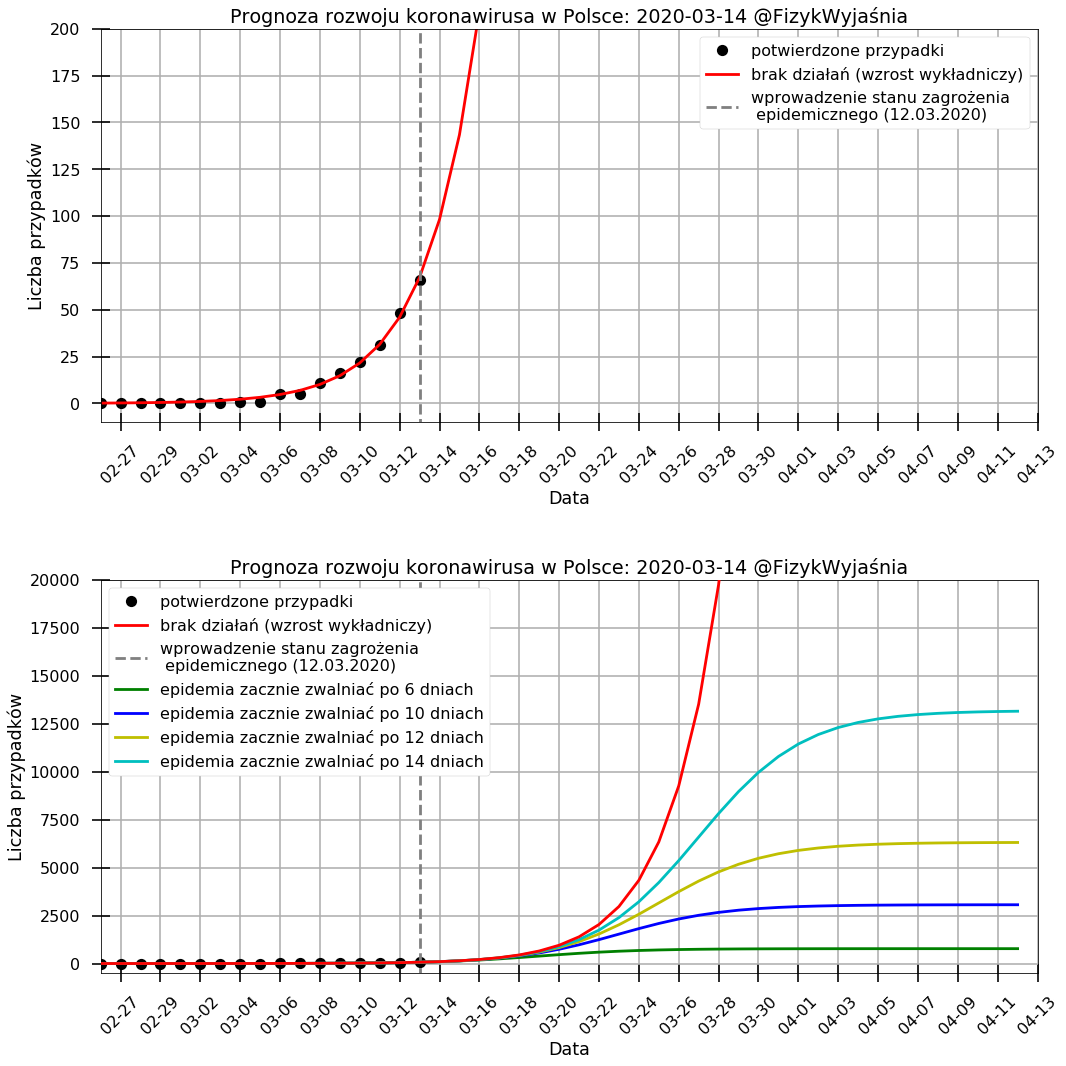

In [29]:
## Create figure and plot space
fig, (ax, ax2) = plt.subplots(2,1, figsize=(16, 16), )

marker = itertools.cycle(('o', 'v', '^', '<', '>', 's', 'p', 'P')) 
color = itertools.cycle(('k','r', 'g', 'b', 'y','c','m'))

title = "Prognoza rozwoju koronawirusa w Polsce: "+time.strftime("%Y-%m-%d")+" @FizykWyjaśnia"
x_label = "Data"
y_label = "Liczba przypadków"
shutdown_label="wprowadzenie stanu zagrożenia \n epidemicznego (12.03.2020)"

## Normalized
#col=next(color)
#ax.plot(dates, pred_data, marker=next(marker), linestyle='', label=considered_countries["predict"], color=col)
#col=next(color)
#ax.plot(mdates.num2date(dates_num_extrapolate+dates_start), pred_exp_fit, color=col, label="brak działań")
    
#for variant_name in fit_variants:
#    col=next(color)
#    ax.plot(mdates.num2date(dates_num_extrapolate+dates_start), pred_sig_fit_fixed[variant_name], color=col, label=variant_name)

#ax.set(xlabel="Data",
#       ylabel="Liczba przypadków na "+str(per_num)+ " osób",
#       title="Aktywne przypadki w przeliczeniu na populację")


## Absolute values
unnorm=countries_populations[considered_countries["predict"]]/per_num
## Absolute zoom
col=next(color)
ax.plot(dates, pred_data*unnorm, marker=next(marker), linestyle='', label="potwierdzone przypadki", color=col)
col=next(color)
ax.plot(mdates.num2date(dates_num_extrapolate+dates_start), pred_exp_fit*unnorm, color=col, label="brak działań (wzrost wykładniczy)")
ax.axvline(date_shutdown, -10, 10000000, label=shutdown_label, linestyle='--', color='gray', )

    

ax.set(xlabel=x_label,
       ylabel=y_label,
       title=title)


marker = itertools.cycle(('o', 'v', '^', '<', '>', 's', 'p', 'P')) 
color = itertools.cycle(('k','r', 'g', 'b', 'y','c','m'))

col=next(color)
ax2.plot(dates, pred_data*unnorm, marker=next(marker), linestyle='', label="potwierdzone przypadki", color=col)
col=next(color)
ax2.plot(mdates.num2date(dates_num_extrapolate+dates_start), pred_exp_fit*unnorm, color=col, label="brak działań (wzrost wykładniczy)", zorder=10)
ax2.axvline(date_shutdown, -10, 10000000, label=shutdown_label, linestyle='--', color='gray', )

for variant_name in fit_variants:
    col=next(color)
    ax2.plot(mdates.num2date(dates_num_extrapolate+dates_start), pred_sig_fit_fixed[variant_name]*unnorm, color=col, label=variant_name)

#col=next(color)
#ax2.plot(mdates.num2date(dates_num_extrapolate+dates_start), pred_sig_fit*unnorm, color=col)

ax2.set(xlabel=x_label,
       ylabel=y_label,
       title=title)

## axes 
for axis in [ax, ax2]:
    ## Define the date format
    tick_spacing=2
    axis.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    date_form = DateFormatter("%m-%d")
    axis.xaxis.set_major_formatter(date_form)
    axis.xaxis.set_tick_params(rotation=45, direction="out")
    axis.tick_params(direction='inout', length=18, colors='k')

    
    #limits
    axis.set_xlim([datetime.date(2020, 2, 26), datetime.date.today() + datetime.timedelta(days=days_to_extrapolate)])# datetime.date(2020, 3, 15)])
    maxy_multip=1.1

    if axis == ax:
        axis.set_ylim(-10,200)
        #axis.set_ylim([-0.1*maxy_multip*np.max(pred_sig_fit),maxy_multip*np.max(pred_sig_fit)])
        #axis.set_ylim([-0.1*maxy_multip*np.max(pred_sig_fit),maxy_multip*np.max(pred_sig_fit)])
    else:
        axis.set_ylim(-500,20000)
        #axis.set_ylim([-0.1*maxy_multip*np.max(pred_sig_fit*unnorm),maxy_multip*np.max(pred_sig_fit*unnorm)])    
        
    legend = axis.legend(frameon=1, facecolor='white', framealpha=1)#, loc='upper left')
    axis.grid(True)

#    frame = legend.get_frame()
#    frame.set_facecolor('green')
#    frame.set_edgecolor('red')
#    frame.set_alpha(1)


fig.tight_layout(pad=5.0) 
plt.show()

timestamp=time.strftime("%Y_%m_%d")

fig.savefig("./predictions_for_poland_figures/prognoza_"+timestamp+".png")